![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit-logo-text.png)
# Chapter 2
Back to [Chapter 1](chapter1.ipynb)

Here we'll test a reduced neuron model using data from the [NeuroElectro](http://neuroelectro.org) project and from the [Allen Brain Institute Cell Types](http://celltypes.brain-map.org) database.  
### We'll test an Izhikevich model against data from a Layer V pyramidal cell in primary visual cortex

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
import pandas as pd
from pathlib import Path
import quantities as pq
import sciunit
import neuronunit
from neuronunit import aibs
from neuronunit.models.reduced import ReducedModel

In [2]:
import quantities as pq
from neuronunit import tests as nu_tests, neuroelectro
neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell
tests = []

dataset_id = 354190013  # Internal ID that AIBS uses for a particular Scnn1a-Tg2-Cre 
                        # Primary visual area, layer 5 neuron.
    
# Obtain the empirical rheobase current from the Allen Brain Insitute Cell Types database.  
observation = aibs.get_observation(dataset_id, 'rheobase')

# Instantiate the corresponding test
rheobase_test = nu_tests.RheobaseTest(observation=observation)
    

# Obtain the empirical input resistance from neuroelectro.org.
observation = nu_tests.InputResistanceTest.neuroelectro_summary_observation(neuron)

# Instantiate the corresponding test
input_resistance_test = nu_tests.InputResistanceTest(observation=observation)

Getting Rheobase cached data value for from AIBS dataset 354190013
Getting Input Resistance data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Input+Resistance


### The Izhikevich model here is defined in an NeuroML2/LEMS file.  
### We will run it using the jNeuroML backend for simplicity, although this is *much* slower than the native NEURON backend.  

In [3]:
# This example is from https://github.com/OpenSourceBrain/IzhikevichModel.
LEMS_MODEL_PATH = Path(neuronunit.__path__[0]).parent / 'docs' / 'data' / 'NeuroML2' / 'LEMS_2007One.xml'
model = ReducedModel(LEMS_MODEL_PATH, name='Vanilla_Model', backend='jNeuroML')

### Let's run the input resistance test first:

In [6]:
score = input_resistance_test.judge(model)
score

Z = -0.53

### This score above shows the normalized value of the input resistance relative to the distribution of input resistances for this cell type found on NeuroElectro.  We can plot the correspond test artifact:

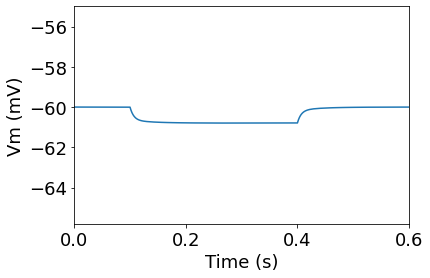

In [7]:
score.plot_vm()

### Let's do the same for the Rheobase, which will take more time.  Since the rheobase observation was a single value obtained from experimental cell, we can't use a Z-score, so let's switch to a RatioScore.

In [8]:
rheobase_test.score_type = sciunit.scores.RatioScore
%time rheobase_test.judge(model)

CPU times: user 16.8 s, sys: 1.36 s, total: 18.1 s
Wall time: 1min 12s


Ratio = 0.40

### The ratio above represents the model's rheobase value relative to the experimental one.  In the course of producing the rheobase, many other values of injected current were checked, so we can look at how many spikes those produced:

Text(0, 0.5, '# of Spikes')

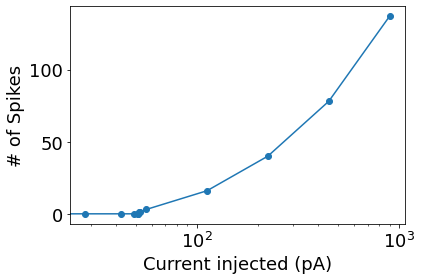

In [14]:
pd.Series(rheobase_test.FI).sort_index().plot(marker='o')
plt.xscale('log')
plt.xlabel('Current injected (pA)')
plt.ylabel('# of Spikes')